# DS 7333 - Quantifying the World
## Case Study #3

Sterling Beason, Sean Kennedy, Emil Ramos

### Introduction
When scrolling through your personal email, it is easy to identify spam mail from a quick glance at the subject line and sender. Although it is not easy to constantly have to scroll through and delete multiple spam mail in a timely manner. So how do we design an automated procedure to classify and eliminate these unwanted massages when scrolling through your inbox?

In order to identify a solution, part of the decision is based on a statistical analysis of the email message that has been hand classified as spam (unwanted mail) or ham (wanted mail). We need to process the email messages into a from conducive to statisitcal analysis. To organize and quantify this information, we can derive variables from characteristics of the messages and use these to classify email. We use a desicion tree that uses derived variables that represent the characteristics of a message, to classify the messages. 

### Objective
Using the “emailDFrp” dataset:

1. Build and evaluate a tree-based model for predicting “spam”
2. Plot and analyze the paths through one (or many) of your trees
3. Explain the parameters involved in “tuning” your model
4. Identify which variables were “most” important
5. Explain how to evaluate the “performance” of your model

### 3.Explain the parameters involved in “tuning” your model

bow = unique list of words. For each word in bow, we compute the number of spam messages in our training set that contain that word. We work our way through the spam messages updating the counts as we encounter additional occurrences of words. Then we collapse these words from across all the spam messages and calculate the frequency table. Because no word is repeated in any message, the frequency of a given word is the number of spam messages in which it occurred. We can then update the elements of subSpamWords that occur in any spam message using the names on the frequency table. We used the same method to estimate the probabilities for a word not being in the message.

isna
Since NA's populated in the test contains a word that is not in the bag of words. When this occured, we included it in our calculation since we have information about the likelihood a message with this word is spam or ham. For the remaining words, we locate the columns in the frequency table that contain them with the logical vector. We ran the data to determine if NA appeared in any of the variables, and if they occured they were identified using T and F. We want to use these values to classify the test messages as spam or ham. A value that is positive indicates spam is more likely and a negative value indicates ham is more likely. We compare the summary statistics of the values for the ham and spam in the test data by comparing the mean/median to identify if there is separation of the ham and spam.

### 4. Identify which variables were "most" important
The variables that played an important part of our model were subSpamWords, isYelling, subBlanks since they did include NA values. For subSpamWords, we identified it being important if the subject contains NA in a spam vector (what were some common words that were in the spam vector). For 'isYelling', if the data contained NA to determine if the subject is all capital letters #how did we quantify the amount of yelling in a message?

subBlanks = percentage of blanks in the subject 

### 5. Explain how to evaluate the performance of your model
We selected precision as our scoring metric to evaluate the performance of our model because it highlights how precise/accurate our model by adding both the true positive and false positive to get a total predicted positive score. It is also a good measure to determine when the costs of false positive is high. In our case study, a false positive means that an email that is ham (actual negative) has been identified as spam (predicted spam). The precision score for our spam detection model must be high to prevent the loss of important emails. 

In [1]:
import pandas as pd
from IPython.display import SVG

# IMPORTANT: install rpy2 v3.3.x
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score

# Recommended Installation: 'conda install python-graphviz' (should add 'graphviz' to PATH)
from graphviz import Source

### Import R Data and Convert to Pandas DataFrame

In [2]:
base = importr('base')
base.load("./Data/data.Rda")
rdf_List = base.mget(base.ls())

with localconverter(ro.default_converter + pandas2ri.converter):
    df = ro.conversion.rpy2py(rdf_List[0]) # convert 'emailDFrp' dataset
    
df = df.reset_index()
df = df.drop('index', 1)

df

,isSpam,isRe,underscore,priority,isInReplyTo,sortedRec,subPunc,multipartText,hasImages,isPGPsigned,...,subQuesCt,numAtt,numRec,perCaps,hour,perHTML,subBlanks,forwards,avgWordLen,numDlr
0,F,T,F,F,T,T,F,F,F,F,...,0,0.0,2,4.451039,11.0,0.000000,12.500000,0.000000,4.376623,3
1,F,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.491289,11.0,0.000000,8.000000,0.000000,4.555556,0
2,F,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.436096,12.0,0.000000,8.000000,0.000000,4.817164,0
3,F,F,F,F,F,T,F,F,F,F,...,0,0.0,0,5.090909,13.0,0.000000,18.918919,3.125000,4.714286,0
4,F,T,F,F,F,T,F,F,F,F,...,0,0.0,1,6.116643,13.0,0.000000,15.217391,6.451613,4.234940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9343,T,F,F,F,F,T,F,F,F,F,...,1,0.0,1,8.572552,21.0,79.657111,13.793103,0.000000,4.700555,2
9344,T,F,F,F,F,T,F,T,F,F,...,0,1.0,1,9.436009,23.0,0.000000,10.526316,0.000000,4.904255,4
9345,T,F,F,F,F,F,F,F,F,F,...,0,0.0,1,2.418448,8.0,0.000000,20.000000,0.000000,4.703704,0
9346,T,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.795400,23.0,0.000000,5.263158,0.000000,5.252690,80


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9348 entries, 0 to 9347
Data columns (total 30 columns):
isSpam           9348 non-null category
isRe             9348 non-null category
underscore       9348 non-null category
priority         9348 non-null category
isInReplyTo      9348 non-null category
sortedRec        9348 non-null category
subPunc          9348 non-null category
multipartText    9348 non-null category
hasImages        9348 non-null category
isPGPsigned      9348 non-null category
subSpamWords     9341 non-null category
noHost           9347 non-null category
numEnd           9348 non-null category
isYelling        9341 non-null category
isOrigMsg        9348 non-null category
isDear           9348 non-null category
isWrote          9348 non-null category
numLines         9348 non-null int32
bodyCharCt       9348 non-null int32
subExcCt         9348 non-null int32
subQuesCt        9348 non-null int32
numAtt           9348 non-null float64
numRec           9348 non-

In [4]:
print(df.isna().any())

isSpam           False
isRe             False
underscore       False
priority         False
isInReplyTo      False
sortedRec        False
subPunc          False
multipartText    False
hasImages        False
isPGPsigned      False
subSpamWords      True
noHost            True
numEnd           False
isYelling         True
isOrigMsg        False
isDear           False
isWrote          False
numLines         False
bodyCharCt       False
subExcCt         False
subQuesCt        False
numAtt           False
numRec           False
perCaps          False
hour             False
perHTML          False
subBlanks         True
forwards         False
avgWordLen       False
numDlr           False
dtype: bool


### Data Partioning

In [5]:
df = df.dropna() # TODO: Impute NAs, don't drop them

features = df[df.columns.difference(['isSpam'])]

X = pd.get_dummies(features, drop_first=True)
y = df['isSpam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7333)

### Modeling - Decision Tree

In [6]:
clf = DecisionTreeClassifier(random_state=7333)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

# Accuracy
accuracy_score(y_test, pred)

0.9603429796355841

### Display Decision Tree

**Note:** You may have to scroll to view

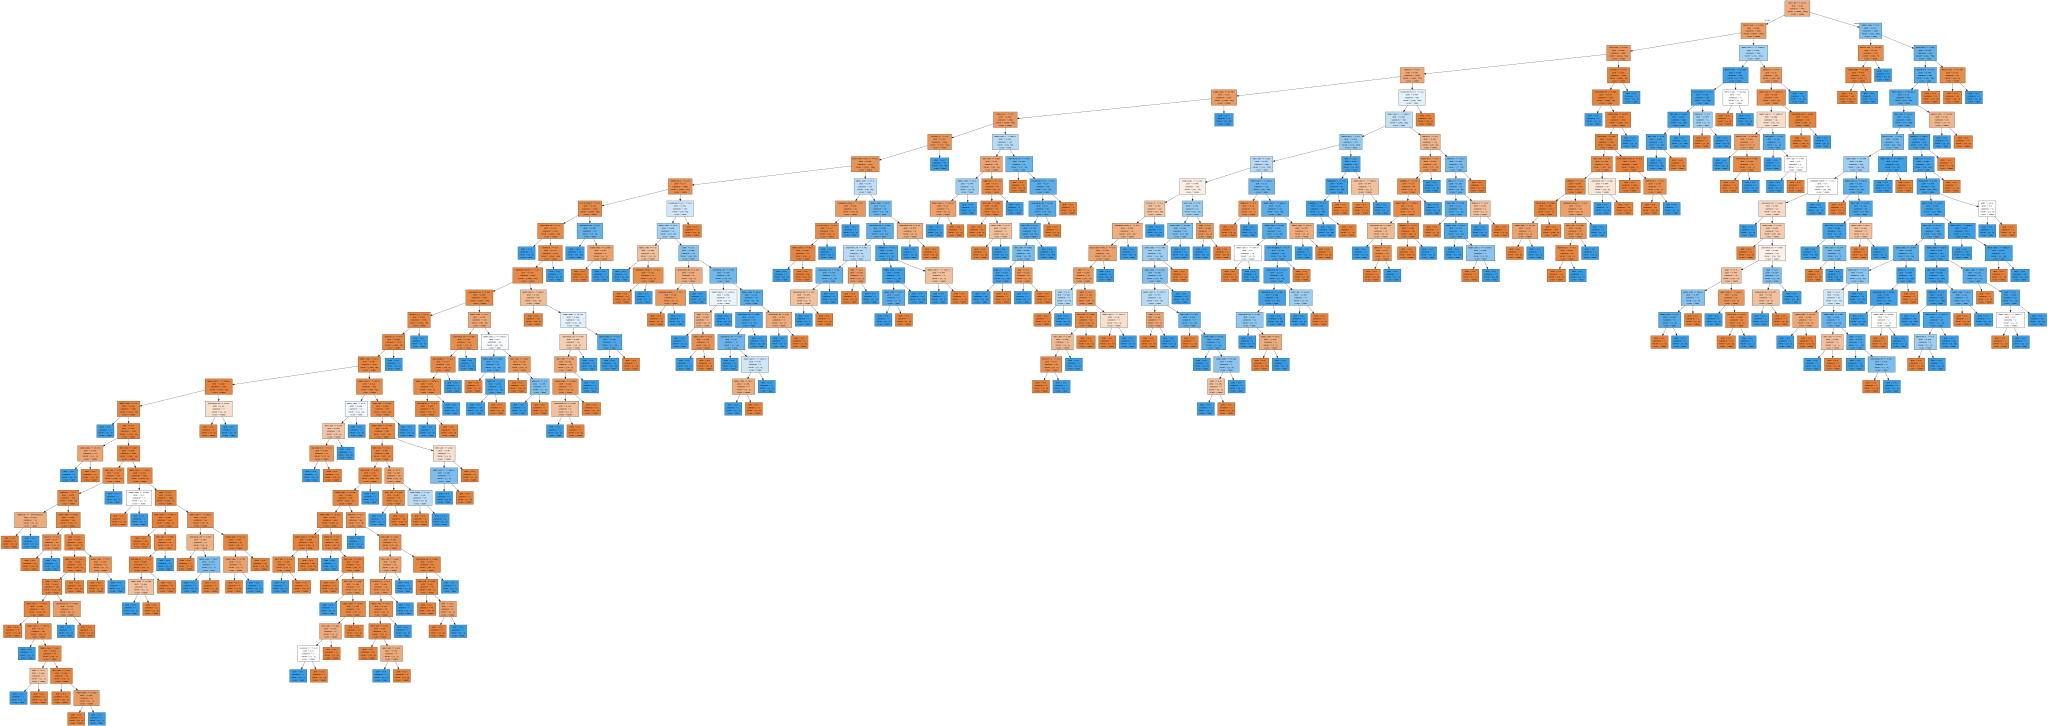

In [7]:
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=['spam', 'ham'], filled = True))

display(SVG(graph.pipe(format='svg')))